# Zero to Hero - Object Detection with Simple ONNX Model

### This notebook is a simplified use-case to:
### 1.  Grab ONNX model
### 2.  ONNX to TRT conversion
### 3.  Inference (object detection)

### <font color='red'>Friction is in red</font>  
This is meant to simulate a new user's DX who already might have experience with other frameworks like PyTorch - albeit, this notebook purposefully avoid Pytorch since I plan to use TensorFlow/Keras


##### <font color='red'>Friction 1</font> - Long Process without warning
##### <font color='red'>Friction 2</font> - Numpy Versioning
  

    

---

# Environment
### This notebook was run in WSL on Windows 11 using and RTX Ada 6K

### Host:

In [1]:
!echo "CPUS: $(nproc)" && echo "MEM:  $(free -h | grep 'Mem:' | awk  '{print $2}')"

CPUS: 32
MEM:  31Gi


In [2]:
!uname -a

Linux NV-773KG04 5.15.133.1-microsoft-standard-WSL2 #1 SMP Thu Oct 5 21:02:42 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


### Device:

In [3]:
!nvidia-smi

Wed Jul 24 18:28:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.01              Driver Version: 555.85       CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  | 00000000:01:00.0 Off |                    0 |
| 30%   32C    P8               9W / 300W |      0MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

___  

# 0. Install Python Dependencies

In [4]:
!printf "tensorrt\npolygraphy\ncolored\nnumpy\nmatplotlib" > requirements.txt

!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.9/346.9 KB 6.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 96.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 109.6 MB/s eta 0:00:00 0:00:01m
Using legacy 'setup.py install' for tensorrt, since package 'wheel' is not installed.
  Running setup.py install for tensorrt ... done


___  

# 1. Grab ONNX Model
### SSD Object Detection
https://github.com/onnx/models/tree/main/validated/vision/object_detection_segmentation/ssd

In [5]:
!rm -rf ssd-10.onnx
!wget https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx

--2024-07-24 18:28:05--  https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx [following]
--2024-07-24 18:28:05--  https://media.githubusercontent.com/media/onnx/models/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80363696 (77M) [application/octet-stream]
Saving to: ‘ssd-10.onnx’

ssd-10.onnx         100%[============

___  

# 2. ONNX to TRT conversion
### [Naive Approach] 

### <font color='red'>Friction 1</font> - No warning about being a long process
### <font color='blue'>Solution</font> - A quick note about at top of output would be nice, "This process can take several minutes depending on..."

In [6]:
%%time

# 2 minutes SDD, 4 minutes Yolo4

from polygraphy.backend.trt import network_from_onnx_path, CreateConfig, engine_from_network, save_engine

!echo "start: $(date +%T)"

network = network_from_onnx_path('ssd-10.onnx')
config = CreateConfig() #fp16=True)
engine = engine_from_network(network, config)
save_engine(engine, path='ssd-10.plan')

start: 18:28:07
[W] ModelImporter.cpp:797: Make sure output labels has Int64 binding.
[I] Configuring with profiles:[
        Profile 0:
            {image [min=[1, 3, 1200, 1200], opt=[1, 3, 1200, 1200], max=[1, 3, 1200, 1200]]}
    ]
[W] profileSharing0806 is on by default in TensorRT 10.0. This flag is deprecated and has no effect.
[I] Building engine with configuration:
    Flags                  | []
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 46067.50 MiB, TACTIC_DRAM: 46067.50 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 33.879 seconds
[I] Saving engine to ssd-10.plan
CPU times: user 16.2 s, sys: 10.5 s, total: 26.7 s
Wall time: 36 s


### Load TensorRT Engine

In [7]:
import tensorrt as trt

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

In [8]:
with open("ssd-10.plan", "rb") as f:
    engine_data = f.read()
engine = trt_runtime.deserialize_cuda_engine(engine_data)
context = engine.create_execution_context()

___  

# 3.  Inference (object detection)

### a - sample image

In [9]:
!rm -rf dog_bike_car.jpg
!wget https://djl.ai/examples/src/test/resources/dog_bike_car.jpg

--2024-07-24 18:28:43--  https://djl.ai/examples/src/test/resources/dog_bike_car.jpg
Resolving djl.ai (djl.ai)... 185.199.109.153, 185.199.108.153, 185.199.111.153, ...
Connecting to djl.ai (djl.ai)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163759 (160K) [image/jpeg]
Saving to: ‘dog_bike_car.jpg’

dog_bike_car.jpg    100%[===================>] 159.92K  --.-KB/s    in 0.02s   

2024-07-24 18:28:43 (8.59 MB/s) - ‘dog_bike_car.jpg’ saved [163759/163759]



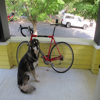

<class 'numpy.ndarray'> (1, 3, 1200, 1200)


In [10]:
from PIL import Image
import numpy as np

pil_img = Image.open('dog_bike_car.jpg')
pil_img = pil_img.resize((1200, 1200))
display(pil_img.resize((100, 100)))
# Transpose to NCHW layout and normalize data.
img = np.transpose(pil_img, (2, 0, 1))
img = np.array(img).astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0)
print(type(img), img.shape)

### b - infer

### <font color='red'>Friction 2</font> - Numpy Versioning
### <font color='blue'>Solution</font> - Fix this code: https://github.com/NVIDIA/TensorRT/blob/main/tools/Polygraphy/polygraphy/backend/base/runner.py#L190

In [12]:
from polygraphy.backend.trt import TrtRunner

with TrtRunner(engine) as runner:
    outputs = runner.infer(feed_dict={"image": img})

AttributeError: `np.unicode_` was removed in the NumPy 2.0 release. Use `np.str_` instead.

### Numpy Fix

In [13]:
!pip uninstall -y numpy

Found existing installation: numpy 2.0.1
Uninstalling numpy-2.0.1:
  Successfully uninstalled numpy-2.0.1


In [14]:
!pip install "numpy<2"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.1 MB/s eta 0:00:00a 0:00:01


In [15]:
import numpy as np
np.__version__

'2.0.1'

### Restart iPython Kernel - then run following code

In [1]:
import numpy as np
np.__version__

'1.26.4'

In [2]:
from polygraphy.backend.trt import TrtRunner
import tensorrt as trt
from PIL import Image
import numpy as np


TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

with open("ssd-10.plan", "rb") as f:
    engine_data = f.read()

engine = trt_runtime.deserialize_cuda_engine(engine_data)
img = Image.open('dog_bike_car.jpg').resize((1200, 1200))
img = np.transpose(img, (2, 0, 1))
img = np.array(img).astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0) 

with TrtRunner(engine) as runner:
    outputs = runner.infer(feed_dict={"image":np.array(img)})

[W] Could not find the CUDA runtime library.
    Note: Paths searched were:
    ['/usr/local/cuda/lib64', '/usr/lib', '/lib']
[W] Attempting to load: 'libcudart.so' using default loader paths


In [3]:
dict(outputs).keys()

dict_keys(['bboxes', 'labels', 'scores'])

##### Bounding Boxes

In [4]:
bboxes = outputs["bboxes"][0]
bboxes.shape

(200, 4)

##### Scores & Labels

In [5]:
scores = outputs["scores"][0]
scores.shape, scores.max(), scores.min()

((200,), 0.7304471, 0.059816286)

In [6]:
labels = outputs["labels"][0]

label_list = []

with open("labels.txt", "r") as f:
    for line in f:
        label_list.extend(line.split())
        
label_dict = {idx: class_name for idx, class_name in enumerate(label_list)}

detected_objects = [(lbl_idx, label_dict[lbl_idx], scr) for lbl_idx, scr in  list(zip(labels, scores))]

detected_objects[:5]

[(2, 'car', 0.7304471),
 (3, 'motorcycle', 0.4977649),
 (8, 'boat', 0.45238298),
 (75, 'laptop', 0.37124574),
 (2, 'car', 0.23678772)]


x- 205.59 y- 294.93 w- 736.29 h- 705.27
(2, 'car', 0.7304471)

-------------------------------------



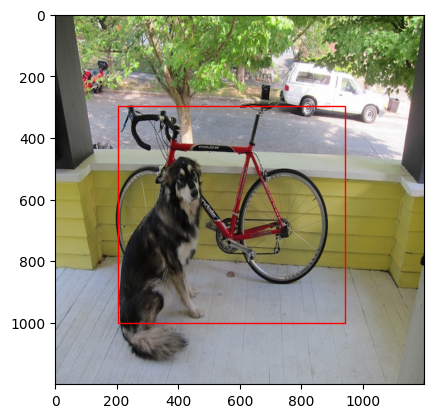

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


scores = outputs["scores"][0]
bboxes = outputs["bboxes"][0]

MAX_BOXES = 1

fig, ax = plt.subplots()
ax.imshow(Image.open('dog_bike_car.jpg').resize((1200, 1200)))

for inference_idx, score in enumerate(scores[:MAX_BOXES]):
    
    x1 = [coord * 1200 for coord in bboxes[inference_idx]][0]
    y1 = [coord * 1200 for coord in bboxes[inference_idx]][1]
    
    x2 = [coord * 1200 for coord in bboxes[inference_idx]][2]
    y2 = [coord * 1200 for coord in bboxes[inference_idx]][3]
    
    w = x2-x1
    h = y2-y1

    print("\nx-",round(x1,2),"y-",round(y1,2),"w-",round(w,2),"h-",round(h,2))
    
    rect = patches.Rectangle(xy=(x1,y1), width=w, height=h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    print(detected_objects[inference_idx])
    print('\n-------------------------------------\n')

plt.show()